In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import keras
import numpy as np
from models import model_v2
from tensor_dlt import TensorDLT
from spatial_transformer import spatial_transformer_network
print(tf.config.list_physical_devices('GPU'))

2024-03-01 14:34:46.370783: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 14:34:46.398946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 14:34:46.398973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 14:34:46.399955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 14:34:46.405369: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-01 14:34:47.624441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 14:34:47.653515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 14:34:47.657567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# dataset
from pathlib import Path
from DataGenerator import DataGenerator

batch_size=8
def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train_Resize"
val_path = Path(root) / "Phase2" / "Data" / "Val_Resize"

rho=32
train_gen = DataGenerator(train_path,
                          mode="unsupervised_with_h4pt",
                          rho=rho,
                          crop_size=128)
val_gen = DataGenerator(val_path,
                          mode="unsupervised_with_h4pt",
                          rho=rho,
                          crop_size=128)


# tensorflow dataset
im_crop_shape = (train_gen.crop_size,train_gen.crop_size,3)
im_ori_shape = (train_gen.resize_shape[1],train_gen.resize_shape[0],3)

output_signature=(  #input
                    (tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=(2,),dtype=tf.float32),
                    ),
                     # output
                    (tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32), 
                     tf.TensorSpec(shape=(8,),dtype=tf.float32))
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen,
                                          output_signature=output_signature)

train_ds = config_ds(train_ds)
val_ds = config_ds(val_ds)

sample_input, sample_output = next(iter(train_ds))
print("input shapes:")
for i in sample_input:
    print(i.shape)
print("output shape")
for i in sample_output:
    print(i.shape)

input shapes:
(8, 128, 128, 3)
(8, 128, 128, 3)
(8, 240, 320, 3)
(8, 2)
output shape
(8, 240, 320, 3)
(8, 8)


2024-03-01 14:34:47.862757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 14:34:47.867522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 14:34:47.871760: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

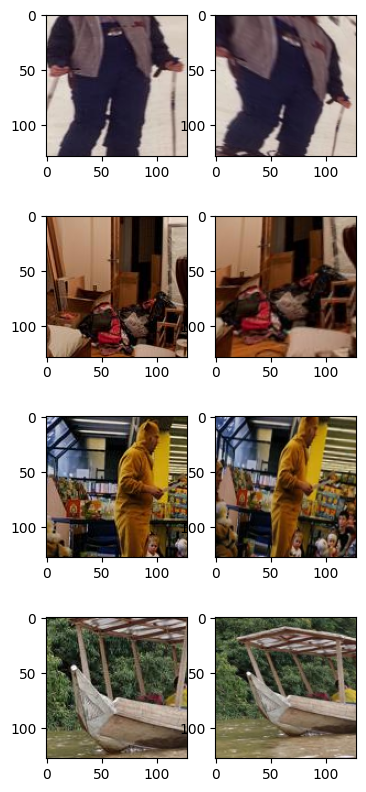

In [4]:
# plot some samples
import matplotlib.pyplot as plt
sample_input, sample_output = next(iter(train_ds))

plt.figure(figsize=(4,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(4,2,2*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
plt.show()

In [5]:
# a = tf.Variable(1.0)
# tf.debugging.check_numerics(a, message='')

# b = tf.Variable(np.nan)
# try:
#   tf.debugging.check_numerics(b, message='Checking b')
#   print("bbbb")
# except Exception as e:
#   assert "Checking b : Tensor had NaN values" in e.message
#   print(e.message)

# c = tf.Variable(np.inf)
# try:
#   tf.debugging.check_numerics(c, message='Checking c')
# except Exception as e:
#   assert "Checking c : Tensor had Inf values" in e.message

In [6]:
import sys
# define loss and metrics
def loss_img(y_true, y_pred):
    # y_true and y_pred are now batch of images
    return tf.reduce_mean(tf.abs(y_true-y_pred)) 
    # notice 1-norm is used


def metric_abs(y_true, y_pred):
    """computes the mean difference between predicted and actual corner shift
    values in x and y direction

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    return tf.reduce_mean(tf.abs(y_true-y_pred))

def metric_dist(y_true, y_pred):
    """compute the l2 distance between corner

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_
    """
    d = tf.reshape(y_true,(-1,4,2))-tf.reshape(y_pred,(-1,4,2))
    return tf.reduce_mean(tf.norm(d,ord='euclidean',axis=-1))

# build new model with TensorDLT and STN added
homography_net = model_v2()
# homography_net.load_weights('./chkpt_weight/checkpoint_mdl_v2_rho32')

# retrieve the input of the network
cropped_img1 = keras.layers.Input(shape=im_crop_shape)
cropped_img2 = keras.layers.Input(shape=im_crop_shape)
img_ori = keras.layers.Input(shape=im_ori_shape)

h4pt_batch = homography_net([cropped_img1,cropped_img2]) # batch by 8
h4pt_batch = tf.clip_by_value(h4pt_batch,clip_value_min=-rho,clip_value_max=rho)

upper_left_corner = keras.layers.Input(shape=(2,)) # batch by 2

# feed the homography net output to the TensorDLT to recover actual homography
homography = TensorDLT(h4pt_batch=h4pt_batch,
                       upper_left_corner=upper_left_corner,
                       batch_size=batch_size)

# use spatial transformer to get predicted image
img_pred = spatial_transformer_network(img_ori,
                                       homography,
                                       img_height=im_ori_shape[0],
                                       img_width=im_ori_shape[1],
                                       )

class FullModel(keras.Model):
    def __init__(self, inputs, outputs):
        super().__init__(inputs=inputs, outputs=outputs)
        self.loss_tracker = keras.metrics.MeanAbsoluteError(name='mae_loss')
        self.metric_h4pt = keras.metrics.MeanAbsoluteError(name='mae_h4pt')
        self.loss_tracker_val = \
            keras.metrics.MeanAbsoluteError(name='val_mae_loss')
        self.metric_h4pt_val = \
            keras.metrics.MeanAbsoluteError(name='val_mae_h4pt')

    # @tf.function
    def train_step(self, data):
        data_in, data_out = data
        with tf.GradientTape() as tape:
            model_out = self(data_in, training=True)
            loss = tf.reduce_mean(keras.losses.mean_absolute_error(
                                                    y_true=data_out[0],
                                                    y_pred=model_out[0]))

        grads = tape.gradient(loss, self.trainable_variables)

        # check if grad has nan, if so simply return
        skip = False
        for g in grads:
            try:
                tf.debugging.check_numerics(g, message='Checking grad')
            except Exception as e:
                tf.print("==================== nan found ====================",)
                skip = True
                break

        if skip is False:
            # do gradient update
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

            self.loss_tracker.update_state(data_out[0], model_out[0])
            self.metric_h4pt.update_state(data_out[-1], model_out[-1])

        return {"mae_loss": self.loss_tracker.result(),
            "mae_h4pt": self.metric_h4pt.result()}
    
    def test_step(self, data):
        data_in, data_out = data
        model_out = self(data_in, training=False)

        self.loss_tracker_val.update_state(data_out[0], model_out[0])
        self.metric_h4pt_val.update_state(data_out[-1], model_out[-1])

        return {"val_mae_loss": self.loss_tracker_val.result(),
            "val_mae_h4pt": self.metric_h4pt_val.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.metric_h4pt]
    
full_model = FullModel(inputs=[cropped_img1,
                                 cropped_img2,
                                 img_ori,
                                 upper_left_corner,
                                 ], 
                        outputs=[img_pred,h4pt_batch])

# rename output layers
full_model.layers[2]._name = 'h4pt_output'
full_model.layers[-1]._name = 'img_output'
full_model.summary()

full_model.load_weights("./chkpt_weight/checkpoint_mdl_unsupervised")

# compile model
full_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3,clipvalue=0.01),
                   run_eagerly=False)


new init


2024-03-01 14:34:49.865641: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-01 14:34:50.199356: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x98e48e0


checking nan
Model: "full_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 h4pt_output (Functional)    (None, 8)                    3777980   ['input_4[0][0]',             
                                                          0          'input_5[0][0]']             
                                                                                                  
 tf.clip_by_value (TFOpLamb  (None, 8)                    0         ['h4pt_o

2024-03-01 14:34:51.245360: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-01 14:34:51.298875: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[-27. -16. -28.   0.  13. -22.  31.  18.]
 [  6. -14.  -7. -29. -11.   9. -29.   0.]
 [ -9.  18. -21.   6.   5. -32.  -9. -10.]
 [ 29.   1. -23.  27. -20.   8.  27. -27.]
 [ 28. -25. -30. -22. -13. -20.  31. -25.]
 [ -7. -28.  25. -31.  29.  -7.   7.  31.]
 [-28.   6. -14. -12. -25.  18. -17.  31.]
 [-32.   4. -11.   3.   6.   8.   1.   2.]], shape=(8, 8), dtype=float32)
tf.Tensor(
[[-25. -25. -14.  11.  -2.   0.  20.   0.]
 [ 11.   8.  17. -12.  -3.   1. -12.   3.]
 [  9.  11.  -9.   8. -13. -10.   5. -10.]
 [ 10.  15. -17.  12. -22. -11.  17. -12.]
 [ 25.   6. -31.  10. -13. -15.   4. -11.]
 [-15. -22.  16.  -9.  15.   9. -23.  27.]
 [-11.   2.  -8.  -2. -23.  12.  14.  12.]
 [-15.  -6. -11.   1.   1.  10.  14.  -4.]], shape=(8, 8), dtype=float32)


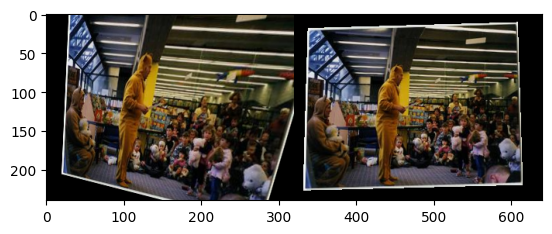

In [7]:
import numpy as np
# try calling the full model with sample input
sample_model_output = full_model(sample_input)
assert(sample_model_output[0].shape==sample_input[2].shape)
print(sample_output[-1])
print(tf.round(sample_model_output[1]))

import matplotlib.pyplot as plt
plt.imshow(np.hstack( ((sample_output[0][2,:,:,:]).numpy(),
                      (sample_model_output[0][2,:,:,:]).numpy())
            )
           )


In [8]:
import numpy as np
steps_per_epoch = int(np.floor(5000/batch_size))

# reduce learning rate when performance plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='mae_loss',
                                                factor=0.2,
                                                patience=3,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=3)

# save check points 
checkpoint_filepath = './chkpt_weight/checkpoint_mdl_unsupervised'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='mae_loss',
                                                mode='min',
                                                save_best_only=True,
                                                verbose=True
                                                )


In [9]:
# start training
for _ in range(10):
    try:
        history = full_model.fit(train_ds,
                                epochs=50,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=val_ds,
                                validation_steps=int(np.floor(1000/batch_size)),
                                validation_freq=1,
                                verbose=True,
                                callbacks=[reduce_lr, checkpoint_callback])
    except:
        full_model.load_weights("./chkpt_weight/checkpoint_mdl_unsupervised")
        print("======================== reset ==========================")


Epoch 1/50


2024-03-01 14:35:05.904452: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb569d5d750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 14:35:05.904477: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-01 14:35:05.907990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709321705.959074   68617 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - ETA: 0s - mae_loss: 0.1595 - mae_h4pt: 12.5316
Epoch 1: mae_loss improved from inf to 0.15947, saving model to ./chkpt_weight/checkpoint_mdl_unsupervised
625/625 [==============================] - 76s 101ms/step - mae_loss: 0.1595 - mae_h4pt: 12.5316 - val_val_mae_loss: 0.1627 - val_val_mae_h4pt: 13.1573 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - ETA: 0s - mae_loss: 0.1596 - mae_h4pt: 12.5970
Epoch 2: mae_loss did not improve from 0.15947
625/625 [==============================] - 62s 99ms/step - mae_loss: 0.1596 - mae_h4pt: 12.5970 - val_val_mae_loss: 0.1622 - val_val_mae_h4pt: 13.0933 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - ETA: 0s - mae_loss: 0.1579 - mae_h4pt: 12.2245
Epoch 3: mae_loss improved from 0.15947 to 0.15786, saving model to ./chkpt_weight/checkpoint_mdl_unsupervised
625/625 [==============================] - 63s 100ms/step - mae_loss: 0.1579 - mae_h4pt: 12.2245 - val_val_mae_los

2024-03-01 14:39:23.017633: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fb78a809200 = {1, 0} Checking grad


======================== reset ==========================
Epoch 1/50
625/625 [==============================] - ETA: 0s - mae_loss: 0.1558 - mae_h4pt: 12.0736
Epoch 1: mae_loss improved from 0.15786 to 0.15577, saving model to ./chkpt_weight/checkpoint_mdl_unsupervised
625/625 [==============================] - 63s 101ms/step - mae_loss: 0.1558 - mae_h4pt: 12.0736 - val_val_mae_loss: 0.1610 - val_val_mae_h4pt: 12.9451 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - ETA: 0s - mae_loss: 0.1555 - mae_h4pt: 11.9290
Epoch 2: mae_loss improved from 0.15577 to 0.15550, saving model to ./chkpt_weight/checkpoint_mdl_unsupervised
625/625 [==============================] - 62s 100ms/step - mae_loss: 0.1555 - mae_h4pt: 11.9290 - val_val_mae_loss: 0.1607 - val_val_mae_h4pt: 12.8827 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - ETA: 0s - mae_loss: 0.1592 - mae_h4pt: 12.3024
Epoch 3: mae_loss did not improve from 0.15550
625/625 [==============================]